In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import os
os.chdir('/content/gdrive/My Drive/')

In [0]:
from keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from keras.preprocessing import image
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D,Dropout,Input
# from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.models import Sequential,Model
from keras import backend as K
from IPython.display import display

In [0]:
data_gen_args = dict(preprocessing_function=preprocess_input, #Define the dictionary for Image data Generator
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True)

train_datagen = image.ImageDataGenerator(**data_gen_args)
test_datagen = image.ImageDataGenerator(**data_gen_args)

In [0]:
base_model  = InceptionV3(weights = 'imagenet', include_top=False)
print('loaded model')

loaded model


In [0]:
train_generator = train_datagen.flow_from_directory("/content/gdrive/My Drive/MDataset/train",
                                                    target_size=(299,299),batch_size=32)

valid_generator = test_datagen.flow_from_directory("/content/gdrive/My Drive/MDataset/test",
                                                     target_size=(299,299),batch_size=32)

Found 1695 images belonging to 2 classes.
Found 607 images belonging to 2 classes.


In [0]:
from keras.layers import Conv2D,MaxPooling2D,Flatten

benchmark = Sequential()
benchmark.add(Conv2D(filters = 16, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (299,299,3)))
benchmark.add(MaxPooling2D(pool_size=2,padding='same'))
benchmark.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
benchmark.add(MaxPooling2D(pool_size=2,padding='same'))
benchmark.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
benchmark.add(MaxPooling2D(pool_size=2,padding='same'))
benchmark.add(Dropout(0.3))
benchmark.add(Flatten())
benchmark.add(Dense(512, activation='relu'))
benchmark.add(Dense(2, activation='softmax'))

benchmark.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 299, 299, 16)      208       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 150, 150, 32)      2080      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 75, 75, 64)        8256      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 38, 38, 64)        0         
__________

In [0]:
benchmark.compile(loss = 'categorical_crossentropy',optimizer='rmsprop', metrics = ['accuracy'])

In [0]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint_path = "benchmark.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Save the model with best weights
checkpointer = ModelCheckpoint(checkpoint_path, verbose=1,save_best_only=True)
# Stop the training if the model shows no improvement 
stopper = EarlyStopping(monitor='val_loss',min_delta=0.1,patience=0,verbose=1,mode='auto')

In [0]:
history = benchmark.fit_generator(train_generator, steps_per_epoch = 13,validation_data=valid_generator,validation_steps=3, epochs=5,verbose=1,callbacks=[checkpointer])

Epoch 1/5
13/13 [==============================] - 260s 20s/step - loss: 8.3852 - acc: 0.4399 - val_loss: 8.6529 - val_acc: 0.4632

Epoch 00001: val_loss improved from inf to 8.65287, saving model to benchmark.hdf5
Epoch 2/5
13/13 [==============================] - 188s 14s/step - loss: 8.9321 - acc: 0.4457 - val_loss: 3.7819 - val_acc: 0.5521

Epoch 00002: val_loss improved from 8.65287 to 3.78189, saving model to benchmark.hdf5
Epoch 3/5
13/13 [==============================] - 87s 7s/step - loss: 6.9819 - acc: 0.5481 - val_loss: 6.8838 - val_acc: 0.5729

Epoch 00003: val_loss did not improve from 3.78189
Epoch 4/5
13/13 [==============================] - 80s 6s/step - loss: 7.0129 - acc: 0.5649 - val_loss: 6.0443 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 3.78189
Epoch 5/5
13/13 [==============================] - 76s 6s/step - loss: 6.4317 - acc: 0.6010 - val_loss: 7.7233 - val_acc: 0.5208

Epoch 00005: val_loss did not improve from 3.78189


Transfer Learning

In [0]:
# Define the output layers for Inceptionv3
last = base_model.output
pool = GlobalAveragePooling2D()(last)
x = Dense(512, activation='relu')(pool)
x = Dropout(0.5)(x)
preds = Dense(2,activation='softmax')(x)

model = Model(input=base_model.input,output=preds)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_99 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


In [0]:
#Load the weights for the common layers from the benchmark model
base_model.load_weights(filepath='benchmark.hdf5',by_name=True)

In [0]:
#Freeze the original layers of Inception3
for layer in base_model.layers:
    layer.trainable = False

In [0]:
#Compile the model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics=['accuracy'])

In [0]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

# Save the model with best weights
checkpointer = ModelCheckpoint('transfer_learning.hdf5', verbose=1,save_best_only=True)
# Stop the traning if the model shows no improvement
stopper = EarlyStopping(monitor='val_loss',min_delta=0.1,patience=1,verbose=1,mode='auto')

In [0]:
# Train the model
history_transfer = model.fit_generator(train_generator, steps_per_epoch = 13,validation_data=valid_generator,validation_steps=4, epochs=5,verbose=1,callbacks=[checkpointer])

In [0]:
display(history_transfer.history)

In [0]:
import matplotlib.pyplot as plt
def plot_training(history):
    acc = history.history['acc'] 
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs  = range(len(acc))
    
    plt.plot(epochs,acc,'b')
    plt.plot(epochs,val_acc,'r')
    plt.title("Training and validation accuracy")
    
    plt.figure()
    plt.plot(epochs,loss,'b')
    plt.plot(epochs,val_loss,'r')
    plt.title("Training and validation loss")
    
    plt.show()

In [0]:
plot_training(history_transfer)

In [0]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 conv2d_98
2 batch_normalization_95
3 activation_95
4 conv2d_99
5 batch_normalization_96
6 activation_96
7 conv2d_100
8 batch_normalization_97
9 activation_97
10 max_pooling2d_8
11 conv2d_101
12 batch_normalization_98
13 activation_98
14 conv2d_102
15 batch_normalization_99
16 activation_99
17 max_pooling2d_9
18 conv2d_106
19 batch_normalization_103
20 activation_103
21 conv2d_104
22 conv2d_107
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_103
29 conv2d_105
30 conv2d_108
31 conv2d_109
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_113
42 batch_normalization_110
43 activation_110
44 conv2d_111
45 conv2d_114
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_110
52 conv2d_112
53

In [0]:
# Load the weights fromt the fine-tuned model
model.load_weights('transfer_learning.hdf5')

In [0]:
from keras.preprocessing.image import img_to_array,load_img
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
def pred(img_path):    
    img = load_img(img_path,target_size = (299,299)) #Load the image and set the target size to the size of input of our model
    x = img_to_array(img) #Convert the image to array
    x = np.expand_dims(x,axis=0) #Convert the array to the form (1,x,y,z) 
    x = preprocess_input(x) # Use the preprocess input function o subtract the mean of all the images
    p = np.argmax(model.predict(x)) # Store the argmax of the predictions
    if p==0:     # P=0 for basal,P=1 for melanoma , P=2 for squamous
        print("benign")
    elif p==1:
        print("melanoma")
    else:
        print("Nothing")

In [0]:
# Unfreeze the last three inception modules
for layer in model.layers[:229]:
    layer.trainable = False
for layer in model.layers[229:]:
    layer.trainable = True

melanoma


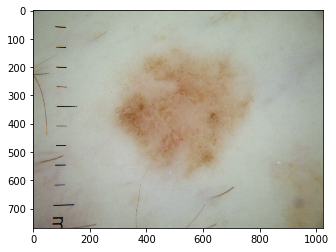

In [0]:
imgPath = '/content/gdrive/My Drive/MDataset/test/malignant/ISIC_0010241.jpg'
pred(imgPath)
z = plt.imread(imgPath) 
plt.imshow(z);         #print the loaded image